# Stitching Images
The results of multiple vertical scans are to be stitched together to form a picture. The various images are stitched after processing into absorption, refraction and scattering images. In a perfect system the images could be simply put together in a montage. In practice there is some variation of the values. When the images are taken there is some overlap between the images. In stitching we will do two things.

1. Use a background area such as air or the plastic holder as a reference. The values of the background should be the same in all images.
2. Determine or give the overlap between images. The images are combined keeping the overlap in mind.

## Setting the root folder
Select the base directory where the data is located. 

1. The results of multiple verticals should be sorted into individual folders in a `results` folder.
2. Default values for the sub-folders were likely used but these can be changed as needed.

In [1]:
# imports
import os.path
import io_files as io
import numpy as np

In [4]:
# folder of results
param = {}
# set the root folders
param["root_dir"] = r"G:\path\to\data"
param["data_dir"] = r"result"
r_path = os.path.join(param["root_dir"], param["data_dir"])
results = [r"Abs", r"Abs_log", r"Refraction", r"USAXS", r"R2", "Area", "Radio"]
test = [os.path.exists(os.path.join(r_path, r)) for r in results]
if not (all(test)):
    print("Warning, not all results were found. Check folder names and folders.")

## Stitch Images
Select a square region to use as a reference. This should be a background area or internal reference that is known to be homogeneous. Note, the area should ideally span the image vertically and be of sufficient size to give good statistical results. This seems to work fairly well for absorption and refraction images but fails badly with USAXS images.

Select an overlap. If the images were collected with a negative step, the images need to be flipped. The overlap region is averaged between the images.

Use a function so that this can be called for each set of results.

In [10]:
ref = [-1, -1, -1, -1]  # [LEFT, RIGHT, TOP, BOTTOM] -1 for limit
dtype = "float"
overlap = 60  # number of pixels of overlap region
invert = True  # flip images if stage was moved up for each step
blend = True  # linear blending
scale = False  # use reference to scale images while merging

# loop over list of results and process each one
final = []
for result in results:
    A = io.stitch_images(
        r_path, result, ref, overlap, flip=invert, scale=scale, blend=blend
    )
    # invert if needed depending on direction of scan
    if not (invert):
        A = np.flipud(A)
    io.save_img(os.path.join(r_path, result + ".tif"), A, dtype)
    final.append(A)

## Look at the results

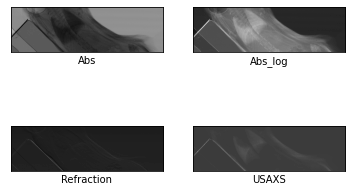

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import exposure
import scipy.ndimage

median_filter = scipy.ndimage.median_filter
m = 3
fig, axs = plt.subplots(ncols=2, nrows=2)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])


def scale(im):
    im = exposure.rescale_intensity(im, out_range="uint8")
    im = im.astype("uint8")
    return im


axs[0, 0].imshow(scale(median_filter(final[0], m)), cmap="gray")
axs[0, 0].set(xlabel="Abs")
axs[0, 1].imshow(scale(median_filter(final[1], m)), cmap="gray")
axs[0, 1].set(xlabel="Abs_log")
axs[1, 0].imshow(scale(median_filter(final[2], m)), cmap="gray")
axs[1, 0].set(xlabel="Refraction")
axs[1, 1].imshow(scale(median_filter(final[3], m)), cmap="gray")
axs[1, 1].set(xlabel="USAXS");